In [1]:
pip install folium, geopandas

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: 'folium,'


# 1. Problem Domain and Data Preparation

<b>Description of Problem Domain:</b>

The problem domain revolves around analysing CO2 emissions in Rwanda. This is crucial for environmental management and policy-making, especially as countries work towards reducing their carbon footprints in line with global climate goals.

<b>Motivation</b>: 
Understanding CO2 emissions helps in assessing the impact of various sectors on climate change and in formulating strategies to mitigate these effects.

<b>Dataset</b>
The dataset comprises open-source emissions data from Sentinel-5P satellites, covering the years 2019 to 2021.

<b>Challenges Faced</b>
1. Missing Values: Often, datasets have incomplete information.
2. Outliers: Certain data points may not fit the expected range and can skew results.
3. Data Size: Handling large datasets can be computationally intensive.

In [2]:
# importing required libaries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import datetime

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

#### Data loading and overview

In [3]:
data = pd.read_csv('data/dataset.csv')
data.head()

,ID_LAT_LON_YEAR_WEEK,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_SO2_slant_column_number_density,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,SulphurDioxide_SO2_column_number_density_15km,CarbonMonoxide_CO_column_number_density,CarbonMonoxide_H2O_column_number_density,CarbonMonoxide_cloud_height,CarbonMonoxide_sensor_altitude,CarbonMonoxide_sensor_azimuth_angle,CarbonMonoxide_sensor_zenith_angle,CarbonMonoxide_solar_azimuth_angle,CarbonMonoxide_solar_zenith_angle,NitrogenDioxide_NO2_column_number_density,NitrogenDioxide_tropospheric_NO2_column_number_density,NitrogenDioxide_stratospheric_NO2_column_number_density,NitrogenDioxide_NO2_slant_column_number_density,NitrogenDioxide_tropopause_pressure,NitrogenDioxide_absorbing_aerosol_index,NitrogenDioxide_cloud_fraction,NitrogenDioxide_sensor_altitude,NitrogenDioxide_sensor_azimuth_angle,NitrogenDioxide_sensor_zenith_angle,NitrogenDioxide_solar_azimuth_angle,NitrogenDioxide_solar_zenith_angle,Formaldehyde_tropospheric_HCHO_column_number_density,Formaldehyde_tropospheric_HCHO_column_number_density_amf,Formaldehyde_HCHO_slant_column_number_density,Formaldehyde_cloud_fraction,Formaldehyde_solar_zenith_angle,Formaldehyde_solar_azimuth_angle,Formaldehyde_sensor_zenith_angle,Formaldehyde_sensor_azimuth_angle,UvAerosolIndex_absorbing_aerosol_index,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,UvAerosolIndex_solar_azimuth_angle,UvAerosolIndex_solar_zenith_angle,Ozone_O3_column_number_density,Ozone_O3_column_number_density_amf,Ozone_O3_slant_column_number_density,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Ozone_sensor_azimuth_angle,Ozone_sensor_zenith_angle,Ozone_solar_azimuth_angle,Ozone_solar_zenith_angle,UvAerosolLayerHeight_aerosol_height,UvAerosolLayerHeight_aerosol_pressure,UvAerosolLayerHeight_aerosol_optical_depth,UvAerosolLayerHeight_sensor_zenith_angle,UvAerosolLayerHeight_sensor_azimuth_angle,UvAerosolLayerHeight_solar_azimuth_angle,UvAerosolLayerHeight_solar_zenith_angle,Cloud_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_top_height,Cloud_cloud_base_pressure,Cloud_cloud_base_height,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,Cloud_solar_azimuth_angle,Cloud_solar_zenith_angle,emission
0,ID_-0.510_29.290_2019_00,-0.51,29.29,2019,0,-0.000108,0.603019,-0.000065,0.255668,-98.593887,50.843559,-130.050797,35.874496,-0.000027,0.035370,1589.024536,4061.098145,829530.500000,71.111977,52.775928,-149.875565,25.965214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000117,0.863230,0.000038,0.255668,35.874496,-130.050797,50.843559,-98.593887,-1.280761,829864.546875,-12.628979,35.632416,-138.786446,30.752128,0.115927,2.506609,0.295663,225.731144,0.595473,-12.628979,35.632416,-138.786446,30.752128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.595473,53534.732422,3664.436218,61085.809570,2615.120483,15.568533,0.272292,-12.628986,35.632416,-138.786423,30.752140,3.750994
1,ID_-0.510_29.290_2019_01,-0.51,29.29,2019,1,0.000021,0.728214,0.000014,0.130988,16.592861,39.137194,-140.874435,28.965133,0.000012,0.036526,1772.574405,1869.040414,829787.287130,-1.019594,38.982368,-140.158048,29.562000,0.000047,1.639765e-05,0.00003,0.000093,7311.869141,-1.935386,0.067038,829859.960368,5.471037,35.265195,-138.343908,30.054262,0.000170,1.172826,0.000143,0.200754,29.071781,-141.814827,43.050213,4.678839,-1.548119,829747.856973,16.152492,43.485327,-142.786141,28.573627,0.116775,2.657704,0.315733,226.172170,0.175166,24.464335,42.596541,-143.097868,28.213655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.213608,63790.296241,3651.190311,66969.478735,3174.572424,8.690601,0.256830,30.359375,39.557633,-145.183930,27.251779,4.025176
2,ID_-0.510_29.290_2019_02,-0.51,29.29,2019,2,0.000514,0.748199,0.000385,0.110018,72.

In [4]:
data.shape

(79023, 76)

Dataset description

Each data point, or row, in the dataset is characterized by four location-based indices (latitude, longitude, year, and week number), 70 descriptive features, and a target variable representing emissions.

Feature Groups:
The 70 features are organized into eight distinct groups, each with a varying number of elements.

1. Sulfur Dioxide
2. Carbon Monoxide
3. Nitrogen Dioxide
4. Formaldehyde
5. UV Aerosol Index 
6. Ozone
7. Cloud
8. UvAerosolLayerHeight

more information about the dataset description can be found <a href='https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S5P_NRTI_L3_SO2?hl=en#bands'>here</a>

### Data cleaning


1. Missing values:

UvAerosolLayerHeigh columns contain a high ratio of missing data points, so they would be dropped off.

2. Categorical features:

'week no' and 'year' would be classified as categorical data.

In [5]:
UvAerosolLayerHeigh_columns = []
for column in data.columns:
    if 'UvAerosolLayerHeigh' in column:
        UvAerosolLayerHeigh_columns.append(column)


with pd.option_context("display.min_rows", 10):
    display(data[UvAerosolLayerHeigh_columns].isna().sum().sort_values())

UvAerosolLayerHeight_aerosol_height           78584
UvAerosolLayerHeight_aerosol_pressure         78584
UvAerosolLayerHeight_aerosol_optical_depth    78584
UvAerosolLayerHeight_sensor_zenith_angle      78584
UvAerosolLayerHeight_sensor_azimuth_angle     78584
UvAerosolLayerHeight_solar_azimuth_angle      78584
UvAerosolLayerHeight_solar_zenith_angle       78584
dtype: int64

In [6]:
data.drop(columns=data[UvAerosolLayerHeigh_columns], axis=1, inplace=True)

In [7]:
# Categorical data
categorical_data = ['year', 'week_no']
for column in categorical_data:
    data[column] = data[column].astype('category')

# 2. Exploratory Data Analysis (EDA)

1. Outliers: 

Sudden spikes in emissions data could be erroneous or due to unusual events.

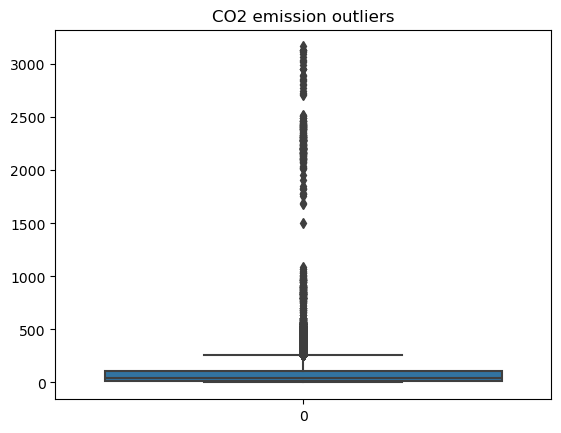

In [8]:
sns.boxplot(data.emission)
plt.title('CO2 emission outliers')  
plt.show()

c:\Users\HomePC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HomePC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


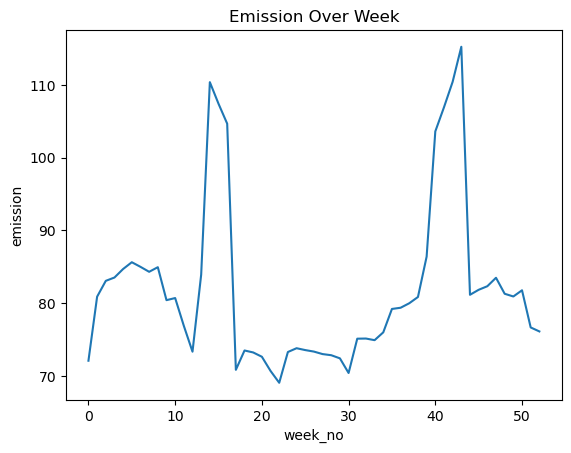

In [9]:
sns.lineplot(data = data, x = 'week_no', y = 'emission', errorbar = None)
plt.title('Emission Over Week')
plt.show()

c:\Users\HomePC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HomePC\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


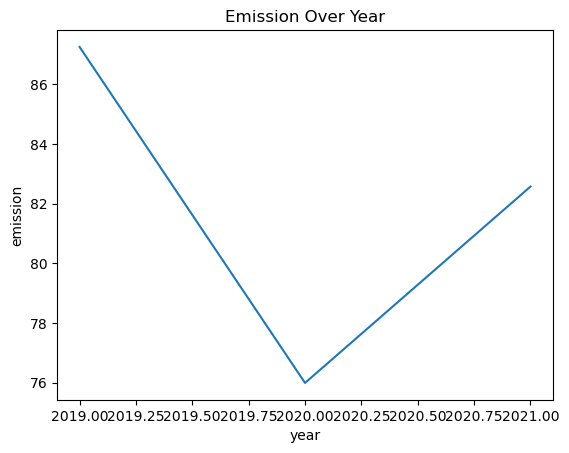

In [10]:
sns.lineplot(data = data, x = 'year', y = 'emission', errorbar = None)
plt.title('Emission Over Year')
plt.show()

2. Locations:

There are 497 locations in the dataset

In [11]:
locations = data.groupby(['latitude', 'longitude']).size().sort_values()
locations.head()

latitude  longitude
-3.299    30.301       159
-1.444    30.856       159
-1.450    29.350       159
-1.482    30.618       159
-1.486    29.614       159
dtype: int64

In [12]:
len(locations)

497

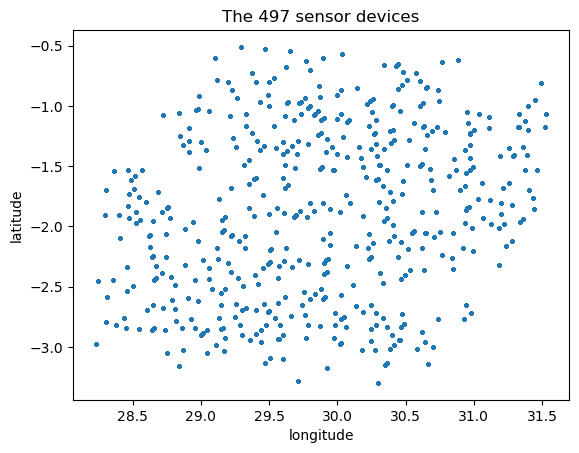

In [13]:
plt.title("The 497 sensor devices")
plt.scatter(data.longitude, data.latitude, s=3)
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

3. Geo Visualization

In [14]:
geometry = gpd.points_from_xy(data.longitude, data.latitude)
geo_df = gpd.GeoDataFrame(
    data[["latitude", "longitude"]], geometry=geometry
)
geo_df.head()

,latitude,longitude,geometry
0,-0.51,29.29,POINT (29.29 -0.51)
1,-0.51,29.29,POINT (29.29 -0.51)
2,-0.51,29.29,POINT (29.29 -0.51)
3,-0.51,29.29,POINT (29.29 -0.51)
4,-0.51,29.29,POINT (29.29 -0.51)


In [15]:
# run cell to view map
'''m = folium.Map(location=[data['latitude'].iloc[0], data['longitude'].iloc[0]], prefer_canvas=True)

for idx, row in data.iterrows():
    folium.CircleMarker(
        location=(row['latitude'], row['longitude']),
        radius=1,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(m)
'''

"# run cell to view map\nm = folium.Map(location=[data['latitude'].iloc[0], data['longitude'].iloc[0]], prefer_canvas=True)\n\nfor idx, row in data.iterrows():\n    folium.CircleMarker(\n        location=(row['latitude'], row['longitude']),\n        radius=1,\n        color='blue',\n        fill=True,\n        fill_color='blue',\n        fill_opacity=0.6\n    ).add_to(m)\n"

Correlation Analysis

There is not a strong correlation among these features in respect to the target (Emission)

In [16]:
corr_features = abs(data.drop(columns=['ID_LAT_LON_YEAR_WEEK'], axis=1).corr()['emission']).sort_values(ascending = False).head(10)
corr_features

emission                                                    1.000000
longitude                                                   0.102746
Cloud_surface_albedo                                        0.046587
CarbonMonoxide_H2O_column_number_density                    0.043217
CarbonMonoxide_CO_column_number_density                     0.041328
Formaldehyde_tropospheric_HCHO_column_number_density_amf    0.040263
NitrogenDioxide_solar_azimuth_angle                         0.033417
Formaldehyde_tropospheric_HCHO_column_number_density        0.033333
SulphurDioxide_solar_azimuth_angle                          0.032338
Formaldehyde_solar_azimuth_angle                            0.030815
Name: emission, dtype: float64

Categorical Analysis

C:\Users\HomePC\AppData\Local\Temp\ipykernel_3536\4022627982.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(column)['emission'].mean().sort_values(ascending=False).head(10)


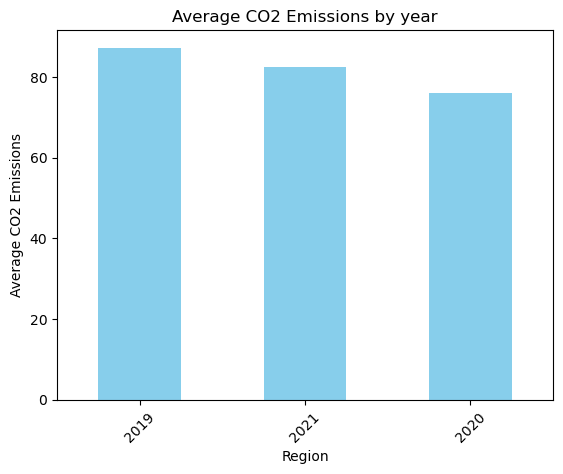

C:\Users\HomePC\AppData\Local\Temp\ipykernel_3536\4022627982.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = data.groupby(column)['emission'].mean().sort_values(ascending=False).head(10)


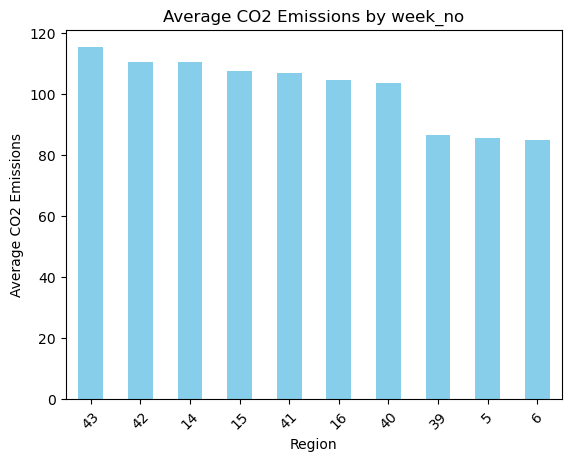

In [17]:
def cat_colum(column):
    grouped_data = data.groupby(column)['emission'].mean().sort_values(ascending=False).head(10)
    grouped_data.plot(kind='bar', color='skyblue')
    plt.title(f'Average CO2 Emissions by {column}')
    plt.xlabel('Region')
    plt.ylabel('Average CO2 Emissions')
    plt.xticks(rotation=45)
    plt.show()
    
for column in categorical_data:
    cat_colum(column)

<b>Feature Engineering</b>

Created three features from the data.

Month: derived from year and week number

Is_covid: derived from year ranging from March 2020 and January 2021

Is_lockdown: derived from year ranging from March-April 2024.

In [18]:
data['month'] = data[['year', 'week_no']].apply(lambda row: datetime.datetime.strptime(f'{row["year"]}-{row["week_no"]+1}-1', "%Y-%W-%w").month, axis=1)
data['is_covid'] = (data['year'] == 2020) & (data['month'] > 2) | (data['year'] == 2021) & (data['month'] == 1)
data['is_covid'] = data['is_covid'].astype(np.int64)
data['is_lockdown'] = (data['year'] == 2020) & ((data['month'].isin([3,4]))) 
data['is_lockdown'] = data['is_lockdown'].astype(np.int64)
data.shape

(79023, 72)

# 3. Encoding Scheme & PCA for Dimensionality Reduction

Encoding categorical data

In [19]:
X = data.drop(columns=['ID_LAT_LON_YEAR_WEEK', 'emission'], axis=1)
y = data['emission']

categorical_data = X.select_dtypes(include=['category']).columns.tolist()
onehot_encoder = OneHotEncoder(drop='first')
encoded_data = onehot_encoder.fit_transform(X[categorical_data])
X = X.drop(columns=categorical_data).reset_index(drop=True)
X = pd.concat([X, pd.DataFrame(encoded_data.toarray(), columns=onehot_encoder.get_feature_names_out(categorical_data))], axis=1)
X.shape

(79023, 122)

Dimensinality Reduction

C:\Users\HomePC\AppData\Local\Temp\ipykernel_3536\4226495164.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = X.fillna(method='ffill').fillna(method='bfill')


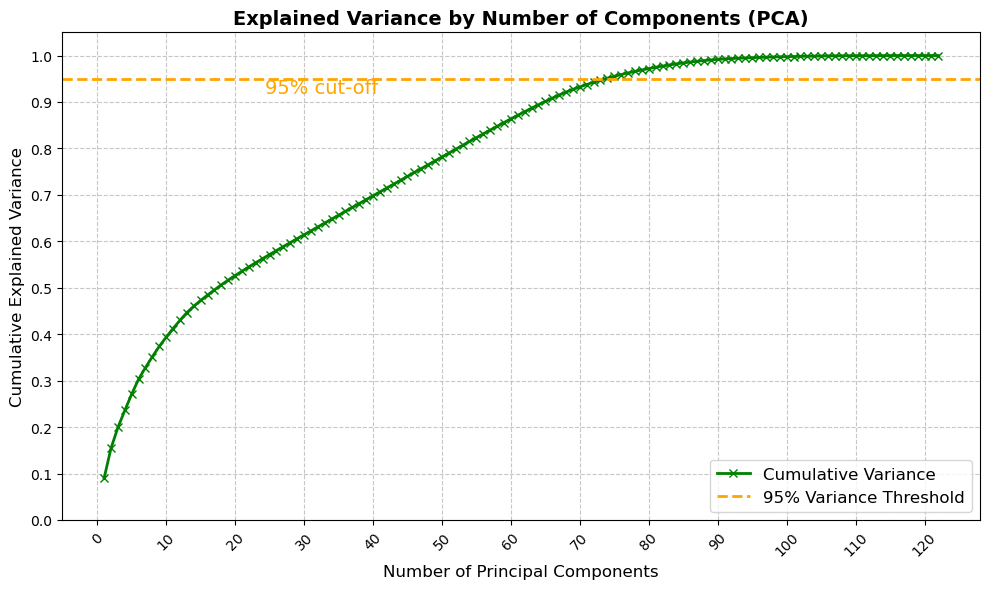

In [20]:
# fill missing values and scale the data
X = X.fillna(method='ffill').fillna(method='bfill')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# apply pca and calculate the cum variance
pca = PCA()
pca.fit(X_scaled)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
components = np.arange(1, len(cumulative_variance) + 1)

plt.plot(components, cumulative_variance, marker='x', linestyle='-', color='g', lw=2, label='Cumulative Variance')

plt.axhline(y=0.95, color='orange', linestyle='--', lw=2, label='95% Variance Threshold')
plt.text(len(cumulative_variance) * 0.2, 0.92, '95% cut-off', color='orange', fontsize=14)

plt.xticks(np.arange(0, len(cumulative_variance) + 1, step=10), fontsize=10, rotation=45)
plt.yticks(np.linspace(0, 1.1, num=12), fontsize=10)
plt.ylim(0, 1.05)

plt.xlabel('Number of Principal Components', fontsize=12)
plt.ylabel('Cumulative Explained Variance', fontsize=12)
plt.title('Explained Variance by Number of Components (PCA)', fontsize=14, fontweight='bold')

plt.legend(loc='best', fontsize=12)
plt.grid(True, which='both', axis='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Key Interpretation

The curve shows that the first few principal components capture a significant amount of the variance in the dataset. For example, the first 40–50 components account for roughly 70-80% of the variance. This indicates that most of the important patterns and variability in the data are captured by these early components.

The orange dashed line marks the point where 95% of the variance is explained. Based on the plot, it appears that around 75 components are required to explain 95% of the variance.
This means that out of the 122 features in the dataset, we can reduce the dimensionality to 75 components while retaining almost all of the original information (95% of it).